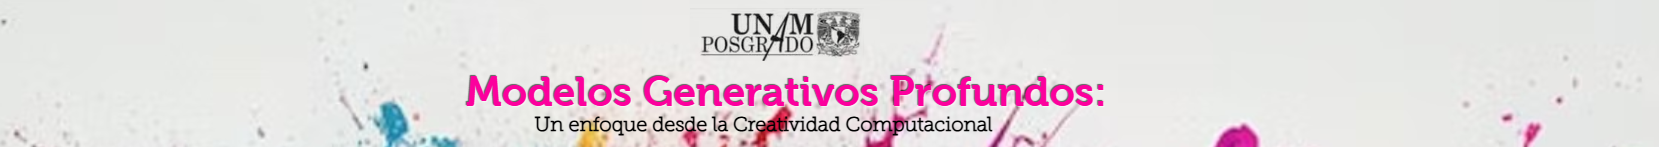

# Exploración del Decodificador de DALL·E 2 (Kandinsky 2.2)

Este notebook permite **probar el comportamiento del *decoder*** de un modelo tipo DALL·E 2,
utilizando la implementación abierta **Kandinsky 2.1** de Hugging Face.  

El *decoder* es el componente que **convierte embeddings visuales en imágenes finales**,
guiado por el texto del prompt.  

Flujo:
Texto → Prior → Decoder → Imagen.



## 1. Instalar dependencias

## 2. Importar librerías

In [1]:
import torch
from diffusers import KandinskyPipeline, KandinskyPriorPipeline
from PIL import Image
import matplotlib.pyplot as plt

/Users/roicort/GitHub/PCIC/GenAI/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Cargar los modelos (Prior + Decoder)

In [2]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline
import torch

# Selección del dispositivo y carga del modelo CLIP

import os 

def setConfig():
    """
    Configura el dispositivo para PyTorch y spaCy según la disponibilidad de hardware.
    Devuelve el dispositivo configurado.
    """
    if torch.backends.mps.is_available():
        # Usar MPS (Metal Performance Shaders) en macOS
        device = torch.device("mps")
    elif torch.cuda.is_available():
        # Usar CUDA (GPU NVIDIA) si está disponible
        device = torch.device("cuda")
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    else:
        # Usar CPU como fallback
        device = torch.device("cpu")
    try:
        torch.ones(1, device=device)
    except Exception as e:
        print("Error:", e)
        raise e
    
    return device

device = setConfig()

# 1. Cargar el prior (texto → embeddings visuales)
prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior",
    torch_dtype=torch.float16
).to(device)

# 2. Cargar el decodificador
decoder = KandinskyPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1",
    torch_dtype=torch.float16
).to(device)

# 3. Definir prompt
prompt = "a watercolor painting of a cat wearing a space helmet"

# 4. Generar embeddings a partir del texto
prior_output = prior(prompt)
image_embeds = prior_output.image_embeds
negative_image_embeds = prior_output.negative_image_embeds

# 5. Generar imagen desde los embeddings
result = decoder(
    image_embeds=image_embeds,
    negative_image_embeds=negative_image_embeds,
    prompt=prompt,
    num_inference_steps=25
)

# 6. Mostrar resultado
image = result.images[0]
image.show()




Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environ

## 4. Generar embeddings visuales desde el texto

In [3]:
prompt = "a watercolor painting of a cat wearing a space helmet"

# 1. Generar ambos embeddings con el prior
prior_output = prior(prompt)
image_embeds = prior_output.image_embeds
negative_image_embeds = prior_output.negative_image_embeds  # <- necesario

# 2. Decodificar con el pipeline
image = decoder(
    image_embeds=image_embeds,
    negative_image_embeds=negative_image_embeds,  # <- agregado
    prompt=prompt,
    num_inference_steps=50
).images[0]

image.show()


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 5. Generar imagen con el decodificador

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


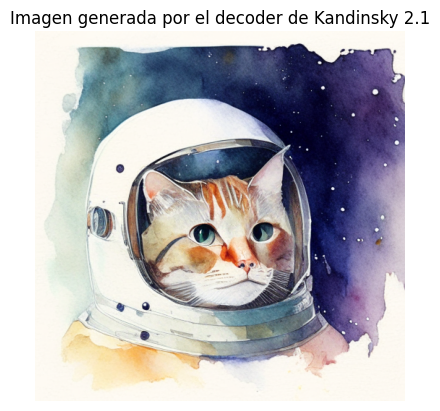

In [4]:
# 1. Obtener ambos embeddings con el prior
prior_output = prior(prompt)
image_embeds = prior_output.image_embeds
negative_image_embeds = prior_output.negative_image_embeds  # ← obligatorio

# 2. Usar el decodificador para generar la imagen final
result = decoder(
    image_embeds=image_embeds,
    negative_image_embeds=negative_image_embeds,  # ← agregado
    prompt=prompt,
    num_inference_steps=50
)

# 3. Mostrar la imagen resultante
image = result.images[0]
plt.imshow(image)
plt.axis("off")
plt.title("Imagen generada por el decoder de Kandinsky 2.1")
plt.show()



## 6. Prueba adicional: generar varias imágenes con diferentes prompts

100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


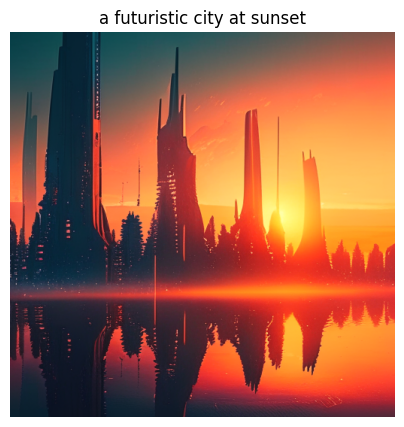

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


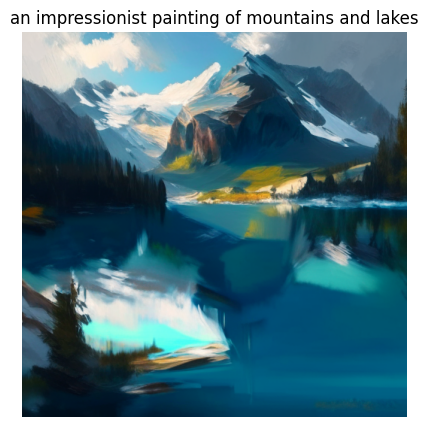

100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


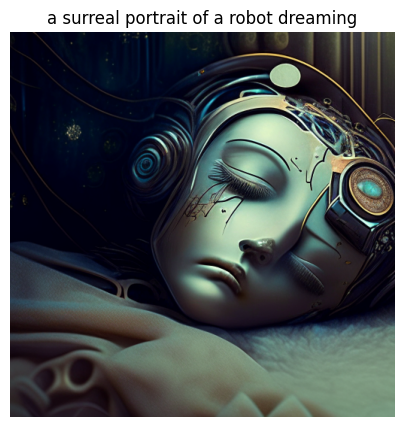

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


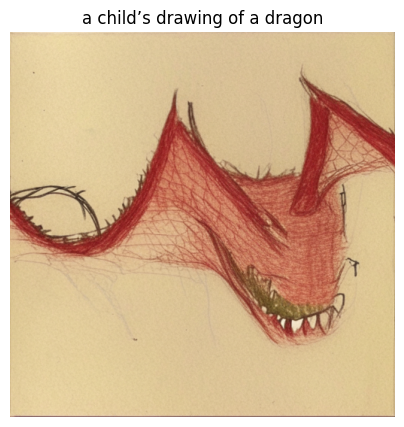

In [5]:
# Prueba con nuevos prompts
prompts = [
    "a futuristic city at sunset",
    "an impressionist painting of mountains and lakes",
    "a surreal portrait of a robot dreaming",
    "a child’s drawing of a dragon"
]

for p in prompts:
    # 1. Generar ambos embeddings con el prior
    prior_output = prior(p)
    image_embeds = prior_output.image_embeds
    negative_image_embeds = prior_output.negative_image_embeds  # <- necesario

    # 2. Usar el decodificador para generar la imagen
    result = decoder(
        image_embeds=image_embeds,
        negative_image_embeds=negative_image_embeds,  # <- agregado
        prompt=p,
        num_inference_steps=50
    )

    # 3. Mostrar el resultado
    img = result.images[0]
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(p, fontsize=12)
    plt.show()
